In [1]:
import os

# Check if the notebook is running on Colab
if 'COLAB_GPU' in os.environ:
    # This block will run only in Google Colab
    IN_COLAB = True
    print("Running on Google Colab. Cloning the repository.")
    !git clone https://github.com/pedro15sousa/energy-based-models-compression.git
    %cd energy-based-models-compression/notebooks
else: 
    # This block will run if not in Google Colab
    IN_COLAB = False
    print("Not running on Google Colab. Assuming local environment.")

Not running on Google Colab. Assuming local environment.


In [2]:
import sys
sys.path.append('..')  # This adds the parent directory (main_folder) to the Python path

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
import torch.utils.data as data
import torch.nn.utils.prune as prune

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning
    import pytorch_lightning as pl
# Callbacks
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
# Pytorch Summary
try:
    from torchsummary import summary
except ModuleNotFoundError:
    !pip install --quiet torchsummary
    from torchsummary import summary

import numpy as np
import pandas as pd
import json
import copy
import random
import copy
import io

## Imports for plotting
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

from metrics.classifier import VGG
from metrics.scores import frechet_inception_distance, inception_score
from EBM import DeepEnergyModel
from energy_funcs.cnn import CNNModel
from sampler import Sampler
from callbacks import InceptionScoreCallback, \
    FIDCallback, SamplerCallback, OutlierCallback, \
    GenerateImagesCallback

import shutil
if IN_COLAB:
    from google.colab import files

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models"

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device: ", device)

pl.seed_everything(43)
random.seed(43)
np.random.seed(43)


/var/folders/pl/gjvtfzbj4691nr_0pszjdspw0000gn/T/ipykernel_99290/2259638936.py:39: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 43


Device:  cpu


In [7]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial8/"
# Files to download
pretrained_files = ["MNIST.ckpt", "tensorboards/events.out.tfevents.MNIST"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [8]:
# Transformations applied on each image => make them a tensor and normalize between -1 and 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_set = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True,  drop_last=True,  num_workers=2, pin_memory=True)
test_loader  = data.DataLoader(test_set,  batch_size=128, shuffle=False, drop_last=False, num_workers=2)

In [9]:
if os.path.exists('../saved_models/mnist-classifier-1 (1).pth'):
    # Load the best model
    mnist_classifier = VGG()

    if device == 'cuda':
        mnist_classifier.load_state_dict(torch.load('../saved_models/mnist-classifier-1 (1).pth'))
    else:
        mnist_classifier.load_state_dict(torch.load('../saved_models/mnist-classifier-1 (1).pth', map_location=torch.device('cpu')))

    mnist_classifier.to(device)
    print("Model already exists and loaded.")
    summary(mnist_classifier, input_size=(1, 28, 28))
else:
    print("Classifier not found in saved_models. Please run the classifier notebook first.")

Model already exists and loaded.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]           1,280
              ReLU-2          [-1, 128, 28, 28]               0
            Conv2d-3          [-1, 128, 28, 28]         147,584
              ReLU-4          [-1, 128, 28, 28]               0
            Conv2d-5          [-1, 128, 28, 28]         147,584
              ReLU-6          [-1, 128, 28, 28]               0
         MaxPool2d-7          [-1, 128, 14, 14]               0
            Conv2d-8          [-1, 256, 14, 14]         295,168
              ReLU-9          [-1, 256, 14, 14]               0
           Conv2d-10          [-1, 256, 14, 14]         590,080
             ReLU-11          [-1, 256, 14, 14]               0
           Conv2d-12          [-1, 256, 14, 14]         590,080
             ReLU-13          [-1, 256, 14, 14]               0
      

In [10]:
pretrained_filename = os.path.join(CHECKPOINT_PATH, "MNIST_resnet18.ckpt")
model = DeepEnergyModel.load_from_checkpoint(pretrained_filename)
# model = DeepEnergyModel.load_from_checkpoint(pretrained_filename)
summary(model, input_size=(1, 28, 28))
model.to(device)
# pl.seed_everything(43)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
             Swish-2           [-1, 64, 14, 14]               0
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4             [-1, 64, 7, 7]          36,928
             Swish-5             [-1, 64, 7, 7]               0
            Conv2d-6             [-1, 64, 7, 7]          36,928
             Swish-7             [-1, 64, 7, 7]               0
BasicResidualBlock-8             [-1, 64, 7, 7]               0
            Conv2d-9             [-1, 64, 7, 7]          36,928
            Swish-10             [-1, 64, 7, 7]               0
           Conv2d-11             [-1, 64, 7, 7]          36,928
            Swish-12             [-1, 64, 7, 7]               0
BasicResidualBlock-13             [-1, 64, 7, 7]               0
           Conv2d-14            [-1, 1

DeepEnergyModel(
  (cnn): ResNet18(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (swish): Swish()
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (swish1): Swish()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (swish2): Swish()
        (shortcut): Sequential()
      )
      (1): BasicResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (swish1): Swish()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (swish2): Swish()
        (shortcut): Sequential()
      )
    )
    (layer2): Sequential(
      (0): BasicResidualBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (swish1): Swis

In [309]:
from torch.quantization import get_default_qconfig, QConfig

# Define per-channel quantization for Conv2d layers
per_channel_qconfig = get_default_qconfig('x86')

# Define per-tensor quantization for Linear layers
per_tensor_qconfig = QConfig(
    activation=torch.quantization.default_observer,
    weight=torch.quantization.default_weight_observer)

# Apply different qconfigs to different layer types
def apply_custom_qconfig(module):
    if isinstance(module, torch.nn.Conv2d):
        module.qconfig = per_channel_qconfig
    elif isinstance(module, torch.nn.Linear):
        module.qconfig = per_tensor_qconfig

model = model.apply(apply_custom_qconfig)


In [325]:
# scale = 2 / 255  # Example scale
# zero_point = 0  # Example zero-point, for uint8, zero_point is usually 0 or 128

# class Swish(nn.Module):
#     def forward(self, x):
#         x = x * torch.sigmoid(x)
#         return x 

# class CustomSwish(nn.Module):
#     def forward(self, x):
#         x = x * torch.sigmoid(x)
#         x = torch.quantize_per_tensor(x, scale, zero_point, torch.quint8)
#         return x 
    
# class DeQuantSwish(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.dequant = torch.quantization.DeQuantStub()
#         self.swish = CustomSwish()

#     def forward(self, x):
#         x = torch.dequantize(x)
#         return self.swish(x)

# class ModifiedCNNModel(nn.Module):
#     def __init__(self, original_model):
#         super().__init__()
#         # Assuming original_model is your quantized model
#         # Copy all convolutional and linear layers
#         self.conv1 = copy.deepcopy(original_model.cnn_layers[0])
#         self.conv2 = copy.deepcopy(original_model.cnn_layers[2])
#         self.conv3 = copy.deepcopy(original_model.cnn_layers[4])
#         self.conv4 = copy.deepcopy(original_model.cnn_layers[6])
#         self.flatten = copy.deepcopy(original_model.cnn_layers[8])
#         self.linear1 = copy.deepcopy(original_model.cnn_layers[9])
#         self.linear2 = copy.deepcopy(original_model.cnn_layers[11])

#         # Create DeQuantSwish layers
#         self.swish1 = DeQuantSwish()
#         self.swish2 = DeQuantSwish()
#         self.swish3 = DeQuantSwish()
#         self.swish4 = DeQuantSwish()
#         # self.swish5 = Swish()
#         self.swish5 = DeQuantSwish()

#     def quant_init_input(self, x):
#         scale = 0.1  # Example scale
#         zero_point = 0  # Example zero-point, for uint8, zero_point is usually 0 or 128

#         # Quantize the input tensor
#         x = torch.quantize_per_tensor(x, scale, zero_point, torch.quint8)
#         return x

#     def forward(self, x):
#         x = self.quant_init_input(x)
#         print("Initial quantized input:",  x.dequantize().mean().item(), x.dequantize().std().item())

#         x = self.conv1(x)
#         print("After conv1:",  x.dequantize().mean().item(), x.dequantize().std().item())

#         x = self.swish1(x)
#         print("After swish1:",  x.dequantize().mean().item(), x.dequantize().std().item())

#         x = self.conv2(x)
#         print("After conv2:",  x.dequantize().mean().item(), x.dequantize().std().item())

#         x = self.swish2(x)
#         print("After swish2:",  x.dequantize().mean().item(), x.dequantize().std().item())

#         x = self.conv3(x)
#         print("After conv3:",  x.dequantize().mean().item(), x.dequantize().std().item())

#         x = self.swish3(x)
#         print("After swish3:",  x.dequantize().mean().item(), x.dequantize().std().item())

#         x = self.conv4(x)
#         print("After conv4:",  x.dequantize().mean().item(), x.dequantize().std().item())

#         x = self.swish4(x)
#         print("After swish4:",  x.dequantize().mean().item(), x.dequantize().std().item())

#         x = self.flatten(x)
#         print("After flatten:",  x.dequantize().mean().item(), x.dequantize().std().item())

#         x = self.linear1(x)
#         print("After linear1:",  x.dequantize().mean().item(), x.dequantize().std().item())

#         x = self.swish5(x)
#         print("After swish5:",  x.dequantize().mean().item(), x.dequantize().std().item())
       
#         print(self.linear2.weight())
#         x = self.linear2(x)
#         print("After linear2 and before final squeeze:",  x.dequantize().mean().item(), x.dequantize().std().item())
#         # x = torch.dequantize(x)
#         print(x)
#         x = x.squeeze(dim=-1)
#         print("Final output:",  x.dequantize().mean().item(), x.dequantize().std().item())

#         return x

scale = 2 / 255  # Example scale
zero_point = 0  # Example zero-point, for uint8, zero_point is usually 0 or 128

class Swish(nn.Module):
    def forward(self, x):
        x = x * torch.sigmoid(x)
        return x 

class CustomSwish(nn.Module):
    def forward(self, x):
        x = x * torch.sigmoid(x)
        x = torch.quantize_per_tensor(x, scale, zero_point, torch.quint8)
        return x 
    
class DeQuantSwish(nn.Module):
    def __init__(self):
        super().__init__()
        self.dequant = torch.quantization.DeQuantStub()
        self.swish = CustomSwish()

    def forward(self, x):
        x = torch.dequantize(x)
        return self.swish(x)

class ModifiedCNNModel(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        # Assuming original_model is your quantized model
        # Copy all convolutional and linear layers
        self.quant = torch.ao.quantization.QuantStub()
        self.conv1 = copy.deepcopy(original_model.cnn_layers[0])
        self.conv2 = copy.deepcopy(original_model.cnn_layers[2])
        self.conv3 = copy.deepcopy(original_model.cnn_layers[4])
        self.conv4 = copy.deepcopy(original_model.cnn_layers[6])
        self.flatten = copy.deepcopy(original_model.cnn_layers[8])
        self.linear1 = copy.deepcopy(original_model.cnn_layers[9])
        self.linear2 = copy.deepcopy(original_model.cnn_layers[11])
        self.dequant = torch.ao.quantization.DeQuantStub()

        self.swish = Swish()

        # Create DeQuantSwish layers
        # self.swish1 = DeQuantSwish()
        # self.swish2 = DeQuantSwish()
        # self.swish3 = DeQuantSwish()
        # self.swish4 = DeQuantSwish()
        # # self.swish5 = Swish()
        # self.swish5 = DeQuantSwish()

    def quant_init_input(self, x):
        scale = 0.1  # Example scale
        zero_point = 0  # Example zero-point, for uint8, zero_point is usually 0 or 128

        # Quantize the input tensor
        x = torch.quantize_per_tensor(x, scale, zero_point, torch.quint8)
        return x

    def forward(self, x):
        x = self.quant(x)
        print(x.type())
        print("Initial quantized input:",  x.dequantize().mean().item(), x.dequantize().std().item())

        x = self.conv1(x)
        print("After conv1:",  x.dequantize().mean().item(), x.dequantize().std().item())

        x = self.swish(x)
        print("After swish1:",  x.dequantize().mean().item(), x.dequantize().std().item())

        x = self.conv2(x)
        print("After conv2:",  x.dequantize().mean().item(), x.dequantize().std().item())

        x = self.swish(x)
        print("After swish2:",  x.dequantize().mean().item(), x.dequantize().std().item())

        x = self.conv3(x)
        print("After conv3:",  x.dequantize().mean().item(), x.dequantize().std().item())

        x = self.swish(x)
        print("After swish3:",  x.dequantize().mean().item(), x.dequantize().std().item())

        x = self.conv4(x)
        print("After conv4:",  x.dequantize().mean().item(), x.dequantize().std().item())

        x = self.swish(x)
        print("After swish4:",  x.dequantize().mean().item(), x.dequantize().std().item())

        x = self.flatten(x)
        print("After flatten:",  x.dequantize().mean().item(), x.dequantize().std().item())

        x = self.linear1(x)
        print("After linear1:",  x.dequantize().mean().item(), x.dequantize().std().item())

        x = self.swish(x)
        print("After swish5:",  x.dequantize().mean().item(), x.dequantize().std().item())
       
        print(self.linear2.weight())
        x = self.linear2(x)
        print("After linear2 and before final squeeze:",  x.dequantize().mean().item(), x.dequantize().std().item())
        # x = torch.dequantize(x)
        print(x)
        x = x.squeeze(dim=-1)
        print("Final output:",  x.dequantize().mean().item(), x.dequantize().std().item())

        return x

In [223]:
class Swish(nn.Module):
    def forward(self, x):
        x = x * torch.sigmoid(x)
        return x

class QuantBasicResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(QuantBasicResidualBlock, self).__init__()

        self.quant = torch.ao.quantization.QuantStub()

        self.conv1 = nn.quantized.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.swish1 = Swish()

        self.conv2 = nn.quantized.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.swish2 = Swish()

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.quantized.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            )

        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        x = torch.quantize_per_tensor(x, scale=self.conv1.scale, zero_point=self.conv1.zero_point, dtype=torch.quint8)  # Re-quantize

        identity = x

        out = self.conv1(x)
        out = torch.dequantize(out)  # Dequantize before Swish
        out = self.swish1(out)
        out = torch.quantize_per_tensor(out, scale=self.conv2.scale, zero_point=self.conv2.zero_point, dtype=torch.quint8)  # Re-quantize

        out = self.conv2(out)
        # Dequantize 'out' before addition
        out = torch.dequantize(out)

        # Process the shortcut path
        shortcut = self.shortcut(identity)
        if isinstance(shortcut, torch.Tensor) and shortcut.is_quantized:
            shortcut = torch.dequantize(shortcut)

        out += shortcut
        out = self.swish2(out)
        # out = torch.quantize_per_tensor(out, scale=self.conv1.scale, zero_point=self.conv1.zero_point, dtype=torch.quint8)  # Re-quantize

        
        return out


# Modified ResNet18 for quantization
class QuantResNet18(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(QuantResNet18, self).__init__()
        self.in_channels = 64
        self.quant = torch.quantization.QuantStub()  # Quantize the input
        self.conv1 = nn.quantized.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.swish = Swish()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.quantized.Linear(512, num_classes)
        self.dequant = torch.quantization.DeQuantStub()  # Dequantize the output

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(QuantBasicResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(QuantBasicResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x): 
        x = torch.quantize_per_tensor(x, scale=self.conv1.scale, zero_point=self.conv1.zero_point, dtype=torch.quint8)  # Quantize input
        x = self.conv1(x)
        x = torch.dequantize(x)  # Dequantize before Swish
        x = self.swish(x)
        x = self.maxpool(x)
        # x = torch.quantize_per_tensor(x, scale=self.layer1.conv1.scale, zero_point=self.layer1.conv1.zero_point, dtype=torch.quint8)  # Re-quantize

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = torch.quantize_per_tensor(x, scale=self.fc.scale, zero_point=self.fc.zero_point, dtype=torch.quint8)  # Quantize input
        x = self.fc(x)

        # x = self.dequant(x)  # Dequantize output
        return x

In [200]:
# class DeepEnergyModelQuant(pl.LightningModule):

#     def __init__(self, pre_trained_cnn, img_shape, batch_size, alpha=0.1, lr=1e-4, beta1=0.0):
#         super().__init__()
#         self.save_hyperparameters()

#         self.cnn = ModifiedCNNModel(pre_trained_cnn)
#         self.sampler = Sampler(self.cnn, img_shape=img_shape, sample_size=batch_size)
#         self.example_input_array = torch.zeros(1, *img_shape)

#     def forward(self, x):
#         z = self.cnn(x)
#         return z

#     def configure_optimizers(self):
#         # Energy models can have issues with momentum as the loss surfaces changes with its parameters.
#         # Hence, we set it to 0 by default.
#         optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta1, 0.999))
#         scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.97) # Exponential decay over epochs
#         return [optimizer], [scheduler]

#     def training_step(self, batch, batch_idx):
#         # We add minimal noise to the original images to prevent the model from focusing on purely "clean" inputs
#         real_imgs, _ = batch
#         small_noise = torch.randn_like(real_imgs) * 0.005
#         real_imgs.add_(small_noise).clamp_(min=-1.0, max=1.0)

#         # Obtain samples
#         fake_imgs = self.sampler.sample_new_exmps(steps=60, step_size=10)

#         # Predict energy score for all images
#         inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
#         real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

#         # Calculate losses
#         reg_loss = self.hparams.alpha * (real_out ** 2 + fake_out ** 2).mean()
#         cdiv_loss = fake_out.mean() - real_out.mean()
#         loss = reg_loss + cdiv_loss

#         # Logging
#         self.log('loss', loss)
#         self.log('loss_regularization', reg_loss)
#         self.log('loss_contrastive_divergence', cdiv_loss)
#         self.log('metrics_avg_real', real_out.mean())
#         self.log('metrics_avg_fake', fake_out.mean())
#         return loss

#     def validation_step(self, batch, batch_idx):
#         # For validating, we calculate the contrastive divergence between purely random images and unseen examples
#         # Note that the validation/test step of energy-based models depends on what we are interested in the model
#         real_imgs, _ = batch
#         fake_imgs = torch.rand_like(real_imgs) * 2 - 1

#         inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
#         real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

#         cdiv = fake_out.mean() - real_out.mean()
#         self.log('val_contrastive_divergence', cdiv)
#         self.log('val_fake_out', fake_out.mean())
#         self.log('val_real_out', real_out.mean())


class EBMQuant(pl.LightningModule):

    def __init__(self, pre_trained_resnet, img_shape, batch_size, alpha=0.1, lr=1e-4, beta1=0.0):
        super().__init__()
        self.save_hyperparameters()
        self.cnn = pre_trained_resnet
        self.output_energy = nn.quantized.Linear(10, 1)

    def forward(self, x):
        z = self.cnn(x)
        print(z.shape)
        z = self.output_energy(z)
        return z

In [178]:
def quantize_cnn(model):
    original_cnn = copy.deepcopy(model.cnn)

    original_cnn.to('cpu')  # Ensure the model is on CPU for quantization
    original_cnn.eval()
    # original_cnn.qconfig = torch.ao.quantization.get_default_qconfig('x86')
    # prepared_cnn = torch.ao.quantization.prepare(original_cnn)

    qint8_qconfig = torch.quantization.get_default_qconfig('fbgemm')
    qint8_qconfig = torch.quantization.QConfig(
        activation=torch.quantization.MinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_tensor_symmetric),
        weight=torch.quantization.MinMaxObserver.with_args(dtype=torch.qint8)
    )
    original_cnn.qconfig = qint8_qconfig
    prepared_cnn = torch.quantization.prepare(original_cnn)

    # Calibrate with representative data
    with torch.no_grad():
        for data, _ in train_loader:
            prepared_cnn(data)

    # Convert the prepared model to a quantized model
    quantized_cnn = torch.ao.quantization.convert(prepared_cnn)
    return quantized_cnn

In [130]:
quant_resnet = quantize_cnn(model)
torch.save(quant_resnet.state_dict(), "quantized_pretrained_resnet.pth")

# quant_ebm = torch.quantization.quantize_dynamic(quant_ebm, {nn.Linear}, dtype=torch.qint8)

In [224]:
pretrained_state_dict = torch.load("quantized_pretrained_resnet.pth")
modified_resnet = QuantResNet18()
modified_resnet.load_state_dict(pretrained_state_dict, strict=False)

<All keys matched successfully>

In [225]:
quant_ebm = EBMQuant(modified_resnet, img_shape=(1, 28, 28), batch_size=64)
# summary(quant_ebm, input_size=(1, 28, 28))

In [226]:
inputs = torch.zeros((1, 1, 28, 28))  # Example input

scale = 0.1  # Example scale
zero_point = 0  # Example zero-point, for uint8, zero_point is usually 0 or 128

# Quantize the input tensor
# quantized_inputs = torch.quantize_per_tensor(inputs, scale, zero_point, torch.quint8)
output = quant_ebm(inputs)
print(output)

torch.Size([1, 10])
tensor([[0.]], size=(1, 1), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=1.0, zero_point=0)


In [192]:
with torch.no_grad():
    rand_imgs = torch.rand((128,) + quant_ebm.hparams.img_shape).to(quant_ebm.device)
    rand_imgs = rand_imgs * 2 - 1.0
    rand_out = quant_ebm.cnn(rand_imgs).mean()
    print(f"Average score for random images: {rand_out.item():4.2f}")

Average score for random images: 0.00


In [193]:
with torch.no_grad():
    train_imgs,_ = next(iter(train_loader))
    train_imgs = train_imgs.to(quant_ebm.device)
    train_out = quant_ebm.cnn(train_imgs).mean()
    print(f"Average score for training images: {train_out.item():4.2f}")

Average score for training images: 0.00


In [195]:
@torch.no_grad()
def compare_images(model, img1, img2):
    imgs = torch.stack([img1, img2], dim=0).to(model.device)
    score1, score2 = model(imgs).cpu().chunk(2, dim=0)
    # grid = torchvision.utils.make_grid([img1.cpu(), img2.cpu()], nrow=2, normalize=True, range=(-1,1), pad_value=0.5, padding=2)
    # Normalize the images
    img1 = (img1 + 1) / 2  # Rescale images from [-1, 1] to [0, 1]
    img2 = (img2 + 1) / 2
    grid = torchvision.utils.make_grid([img1.cpu(), img2.cpu()], nrow=2, normalize=True, pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4,4))
    plt.imshow(grid)
    plt.xticks([(img1.shape[2]+2)*(0.5+j) for j in range(2)],
               labels=["Original image", "Transformed image"])
    plt.yticks([])
    plt.show()
    print(f"Score original image: {score1.item():4.2f}")
    print(f"Score transformed image: {score2.item():4.2f}")

In [196]:
test_imgs, _ = next(iter(test_loader))
exmp_img = test_imgs[0].to(quant_ebm.device)

torch.Size([2, 10])


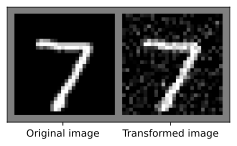

Score original image: 0.00
Score transformed image: 0.00


In [227]:
img_noisy = exmp_img + torch.randn_like(exmp_img) * 0.3
img_noisy.clamp_(min=-1.0, max=1.0)
compare_images(quant_ebm, exmp_img, img_noisy)